In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import PercentFormatter

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

def compute_benefits(filename="file.csv", type_ai=None, group_var=None, group_vals=[], savename="plot", palette=None, measure="Accuracy"):
    data = pd.read_csv(filename)
    
    if ("HD1" not in data.columns):
        return "Mandatory field HD1 is missing!"
    if ("FHD" not in data.columns):
        return "Mandatory field FHD is missing!"
    
    if "Type_AI" not in data.columns:
        data["Type_AI"] = ""

    if group_var is not None:
        data = data[data[group_var].isin(group_vals)]

    
    if type_ai == "all":
        data["Type_AI"] = "AI"
    elif type_ai is not None:
        data = data[data["Type_AI"] == type_ai]
        
    if "Study" not in data.columns:
        data["Study"] = ""
        
    
        
    if ("id" not in data.columns):
        data["id"] = data.index

    data = data.loc[:, ["id","HD1", "FHD", "Type_AI", "Type_H", "Study"]] if "Type_H" in data.columns else data.loc[:, ["id","HD1", "FHD", "Type_AI", "Study"]]
    grouped = data.groupby(["id","Type_AI", "Type_H", "Study"]).mean().reset_index() if "Type_H" in data.columns else data.groupby(["id","Type_AI", "Study"]).mean().reset_index()
    
    for v in grouped["Type_AI"].unique():
        for s in grouped["Study"].unique():
            temp = grouped[(grouped["Type_AI"] == v) & (grouped["Study"] == s)].copy()   
            baseline = temp["HD1"]
            difference = temp["FHD"] - temp["HD1"]
            q25 = np.quantile(baseline, 0.25)
            q75 = np.quantile(baseline, 0.75)
            
            if "Type_H" not in temp.columns:
                temp.loc[:,"Type_H"] = "Others"
                temp.loc[temp["id"].isin(temp.loc[temp["HD1"] <= q25, "id"]), "Type_H"] = "Low performer"
                temp.loc[temp["id"].isin(temp.loc[temp["HD1"] >= q75, "id"]), "Type_H"] = "High performer"
            else:
                temp.loc[:,"Type_H2"] = "Others"
                temp.loc[temp["id"].isin(temp.loc[temp["HD1"] <= q25, "id"]), "Type_H2"] = "Low performer"
                temp.loc[temp["id"].isin(temp.loc[temp["HD1"] >= q75, "id"]), "Type_H2"] = "High performer"
                
            name = savename + str(v) + " (" + str(s) + ")"
            benefit_diagram(baseline, difference, temp["Type_H"] if "Type_H" in temp.columns else temp["Type_H2"], name, palette, measure)

#baseline is a baseline accuracy (e.g., accuracy without AI)
#difference is the difference between two accuracies (e.g., accuracy with AI - accuracy without AI)
def benefit_diagram(baseline, difference, groups, ai_group="", palette=None, measure="Accuracy"):

    if palette is None:
        palette = dict(zip([v for i, v in enumerate(np.unique(groups))],
                            sns.color_palette('colorblind', len(np.unique(groups)))))
    
    plt.figure(figsize=(10,10))
    for i, v in enumerate(np.unique(groups)):
        group_size = groups[groups == v].shape[0]
        plt.scatter(baseline[groups == v], difference[groups == v], color=palette[v], label=v + " (n=" + str(group_size) + ")")

    #sns.scatterplot(x=baseline, y=difference, hue=groups, palette="muted")
    
    #plt.title(ai_group)

    vals = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    plt.fill_between(vals, 1 - vals, alpha=0.3, color="blue" )
    plt.fill_between(vals, - vals, alpha=0.3, color="red" )

    max = np.max(difference)
    min = np.min(difference)
    ax_lim = np.max([max, np.abs(min)])
    
    plt.axhline(np.mean(difference), color="black")
    reg = LinearRegression()
    reg.fit(baseline.values.reshape(-1, 1),difference)
    plt.plot(np.linspace(0,1,10),reg.predict(np.linspace(0,1,10).reshape(-1,1)), 'k--', alpha=0.5, label="All")
    stat = stats.pearsonr(baseline, difference).statistic
    pval = stats.pearsonr(baseline, difference).pvalue
    upp = np.mean(difference) + 1.96*np.std(difference)/np.sqrt(len(difference))
    low = np.mean(difference) - 1.96*np.std(difference)/np.sqrt(len(difference))
    plt.axhline(low, color="black", alpha=0.25)
    plt.axhline(upp, color="black", alpha=0.25)

    if "Others" in np.unique(groups):
        reg_e = LinearRegression()
        reg_e.fit(baseline[groups != "Others"].values.reshape(-1, 1), difference[groups != "Others"])
        plt.plot(np.linspace(0,1,10),reg_e.predict(np.linspace(0,1,10).reshape(-1,1)), 'r--', alpha=0.5, label="Low & High performers")
        stat_e = stats.pearsonr(baseline[groups != "Others"], difference[groups != "Others"]).statistic
        pval_e = stats.pearsonr(baseline[groups != "Others"], difference[groups != "Others"]).pvalue

    
        annot = f'Avg. {measure:s} Diff.: {np.mean(difference):.2f} ({low: .2f}, {upp: .2f})\n\n r: {stat:.2f} (p: {pval:.3f}),   tan(α): {reg.coef_[0]:.2f},   α: {(180 - np.abs(np.rad2deg(np.arctan(reg.coef_[0])))):.2f}\n\n r (Low & High Perf.): {stat_e:.2f} (p: {pval_e:.3f}),   tan(α) (Low & High Perf.): {reg_e.coef_[0]:.2f},   α (Low & High Perf.): {(180 - np.abs(np.rad2deg(np.arctan(reg_e.coef_[0])))):.2f}'
    else:
        annot = f'Avg. {measure:s} Diff.: {np.mean(difference):.2f} ({low: .2f}, {upp: .2f})\n\n r: {stat:.2f} (p: {pval:.3f}),   tan(α): {reg.coef_[0]:.2f},   α: {(180 - np.abs(np.rad2deg(np.arctan(reg.coef_[0])))):.2f}\n\n'

        
    plt.annotate(annot,
                 xy=(0.5, -0.125), ha='center', va='center', xycoords='axes fraction',
                 bbox=dict(facecolor='none', edgecolor='black',boxstyle='round', alpha=0.2))
    plt.xlabel("HD1")
    plt.ylabel("FHD - HD1")
    plt.xlim(0,1)
    plt.ylim(-1.1*ax_lim, 1.1*ax_lim)
    plt.legend(title="User Group")
    plt.savefig("benefit_" + ai_group + ".png", dpi=300, bbox_inches="tight")


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
import numpy as np
import pandas as pd

def paired_plot(filename, type_ai=None, group_user=None, sub=None, sub_vals=[], ai_level=None, savename="plot", palette=None, measure="Accuracy"):
    all_data = pd.read_csv(filename)

    if "Type_AI" not in all_data.columns:
        all_data["Type_AI"] = ""

    if "Study" not in all_data.columns:
        all_data["Study"] = ""

    if type_ai is not None:
        all_data = all_data[all_data["Type_AI"] == type_ai]

    if sub is not None:
        all_data = all_data[all_data[sub].isin(sub_vals)]

    for t in all_data["Type_AI"].unique():
        for s in all_data["Study"].unique():
            data = all_data[(all_data["Type_AI"] == t) & (all_data["Study"] == s)].copy()
            if group_user is None:
                accs = data.groupby("id")["HD1"].mean()
                q25 = np.quantile(accs, 0.25)
                q75 = np.quantile(accs, 0.75)
                data.loc[:,"Type_H"] = "Others"
                data.loc[data["id"].isin(accs[accs <= q25].index), "Type_H"] = "Low performer"
                data.loc[data["id"].isin(accs[accs >= q75].index), "Type_H"] = "High performer"
                loc_group_user = "Type_H"
            else:
                loc_group_user = group_user
                

            if loc_group_user is not None:
                data = data.loc[:,["id","HD1","FHD", loc_group_user]]
            else:
                data = data.loc[:,["id","HD1","FHD"]]
            
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6), gridspec_kw={'width_ratios': [3, 1]})

            
            acc_pre = data.groupby("id")["HD1"].mean().values
            acc_post = data.groupby("id")["FHD"].mean().values
            diff = acc_post - acc_pre
            mean_diff = np.mean(diff)
            ci = 1.96*np.std(mean_diff)/np.sqrt(len(diff))

            x1 = 0.5 + 0.1*np.random.rand(len(data["id"].unique()))
            x2 = 1.5+ 0.1*np.random.rand(len(data["id"].unique()))

            if ai_level is not None:
                staircase = diff[(diff > 0) & (acc_post < ai_level)].shape[0]/diff.shape[0]
                repulsion = diff[(diff < 0) & (acc_pre < ai_level)].shape[0]/diff.shape[0]
                outperformance = diff[(diff > 0) & (acc_post >= ai_level) & (acc_pre < ai_level)].shape[0]/diff.shape[0]
                ballast = diff[(diff < 0) & (acc_pre >= ai_level)].shape[0]/diff.shape[0]
                spur = diff[(diff > 0) & (acc_pre >= ai_level)].shape[0]/diff.shape[0]
                unchanged = diff[(diff == 0)].shape[0]/diff.shape[0]
            
                annot = f'Lifted: {staircase:.2f},   Repulsed: {repulsion:.2f}, Unaffected: {unchanged:.2f},\nOutperformers: {outperformance:.2f}, Ballasted: {ballast:.2f}, Spurred: {spur:.2f}'
            else:
                empowered = diff[(diff > 0)].shape[0]/diff.shape[0]
                undermined = diff[(diff < 0)].shape[0]/diff.shape[0]
                unaffected = diff[(diff == 0)].shape[0]/diff.shape[0]
                annot = f'Empowered: {empowered:.2f}, Unaffected: {unaffected:.2f}, Undermined: {undermined:.2f}'

            # Paired Dot Plot
            if loc_group_user is not None:
                if palette is None:
                    palette = dict(zip([v for _, v in enumerate(np.unique(data[loc_group_user]))],
                                    sns.color_palette('colorblind', len(np.unique(data[loc_group_user])))))
                for i, v in enumerate(np.unique(data[loc_group_user])):
                    acc_pre_v = data[data[loc_group_user] == v].groupby("id")["HD1"].mean().values
                    acc_post_v = data[data[loc_group_user] == v].groupby("id")["FHD"].mean().values
                    x1 = 0.5 + 0.1*np.random.rand(len(data[data[loc_group_user] == v]["id"].unique()))
                    x2 = 1.5+ 0.1*np.random.rand(len(data[data[loc_group_user] == v]["id"].unique()))
                    ax1.plot([x1,x2], [acc_pre_v, acc_post_v], color="gray", alpha=0.5)
                    group_size = data[data[loc_group_user] == v].groupby("id").count().shape[0]
                    ax1.scatter(x1, acc_pre_v, color=palette[v], alpha=0.7, marker='o', label=v + " (n=" + str(group_size) + ")")
                    ax1.scatter(x2, acc_post_v, color=palette[v], alpha=0.7, marker='o')
                    ax1.set_xticks([0.5, 1.5])
                    ax1.set_xticklabels(['HD1', 'FHD'])
                    ax1.set_ylabel(measure)
                    ax1.set_title('Paired Dot Plot')

                    diff_v = acc_post_v - acc_pre_v
                    mean_diff_v = np.mean(diff_v)
                    ci_v = 1.96*np.std(mean_diff_v)/np.sqrt(len(diff_v))
                    ax2.errorbar(x=np.random.normal(loc=0.0, scale=0.1), y=mean_diff_v, xerr=ci_v, fmt='o', color=palette[v], capsize=5)
                
                if ai_level is not None:
                    ax1.axhline(y=ai_level, color='grey', linestyle='--', label="AI")
                ax1.legend()

            else:
                ax1.plot([x1,x2], [acc_pre, acc_post], color="gray", alpha=0.5)
                ax1.scatter(x1, acc_pre, color='black', alpha=0.7, marker='o')
                ax1.scatter(x2, acc_post, color='black', alpha=0.7, marker='o')
                ax1.set_xticks([0.5, 1.5])
                ax1.set_xticklabels(['HD1', 'FHD'])
                ax1.set_ylabel(measure)
                ax1.set_title('Paired Dot Plot')

                ax2.errorbar(x=0, y=mean_diff, xerr=ci, fmt='o', color='black', capsize=5)
                if ai_level is not None:
                    ax1.axhline(y=ai_level, color='grey', linestyle='--', label="AI")
                ax1.legend()
            
            ax2.axhline(y=0, color='grey', linestyle='--')  # Nil difference line
            ax2.set_xlim(-1, 1)
            ax2.set_ylim(-1, 1)
            ax2.set_title('Mean Difference')

            
            # Move the vertical axis to the right side
            ax2.set_xlabel(None)
            ax2.set_ylabel(None)
            ax2.set_xticks([])
            ax2.yaxis.tick_right()
            ax2.yaxis.set_label_position("right")

            ax1.spines[['right', 'top']].set_visible(False)
            ax2.spines[['left', 'top', 'bottom']].set_visible(False)

            ax1.annotate(annot,
                        xy=(0.5, -0.125), ha='center', va='center', xycoords='axes fraction',
                        bbox=dict(facecolor='none', edgecolor='black',boxstyle='round', alpha=0.2))

            plt.tight_layout()
            plt.savefig(savename + (sub_vals[0] if sub is not None else "") + " " + t + " " + s +"_paired.png", dpi=300)

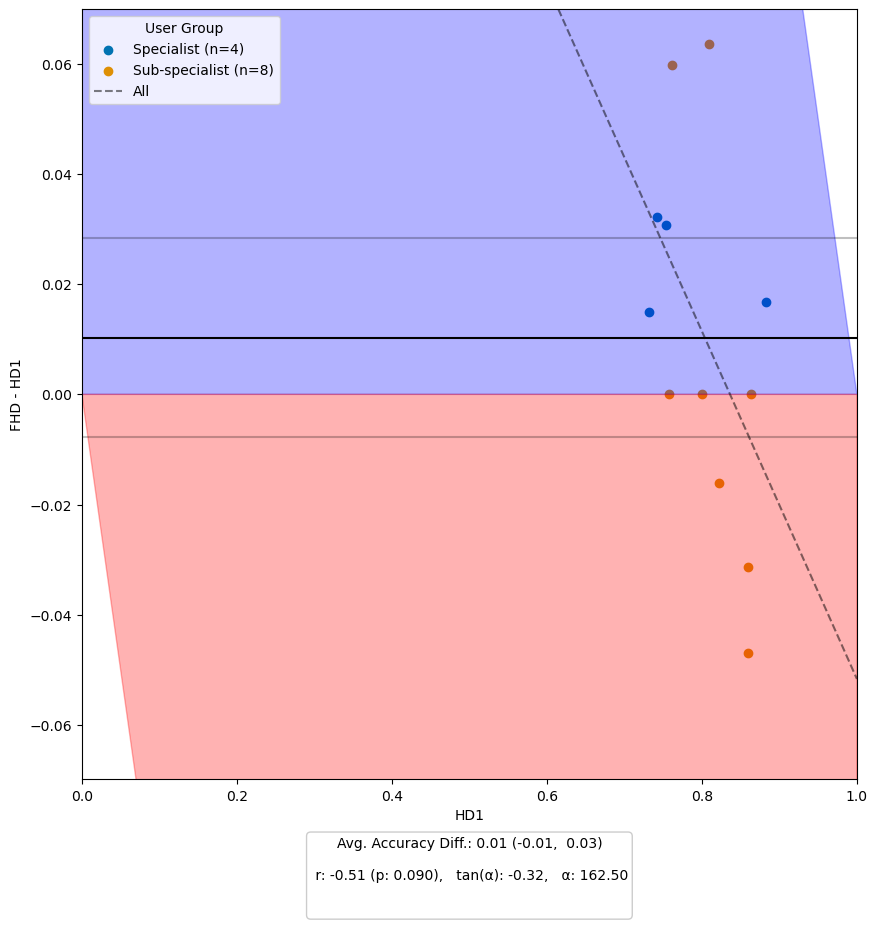

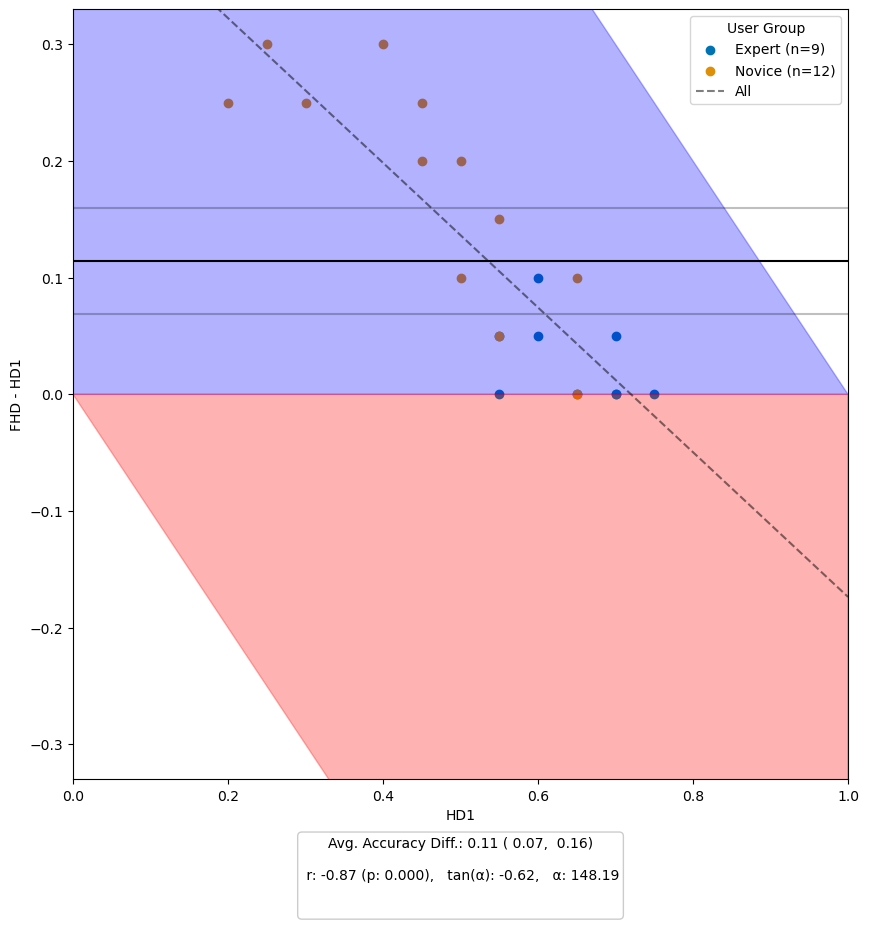

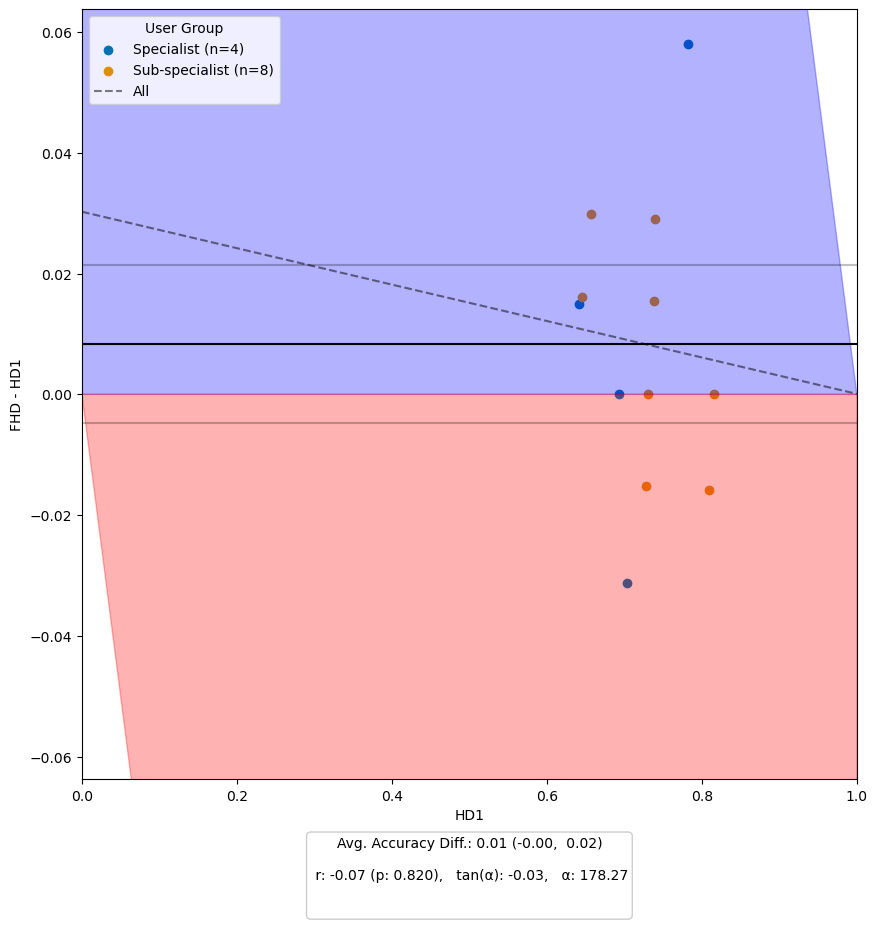

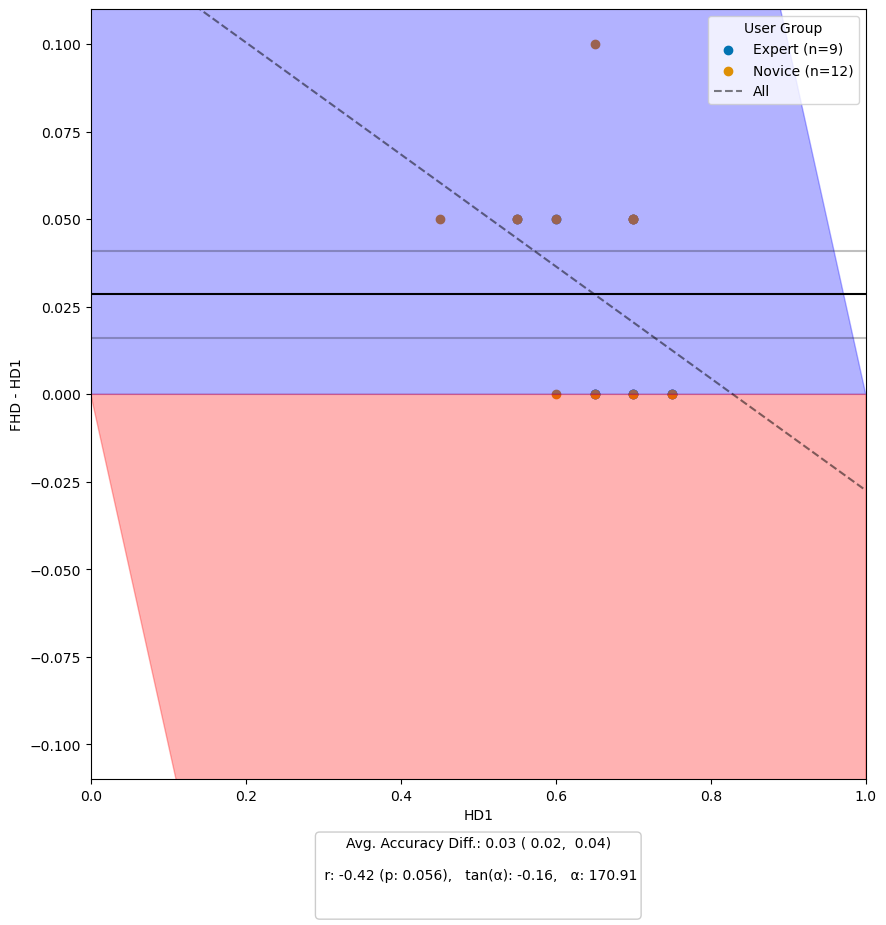

In [4]:
filename = "../data/sample_data.csv"
compute_benefits(filename)

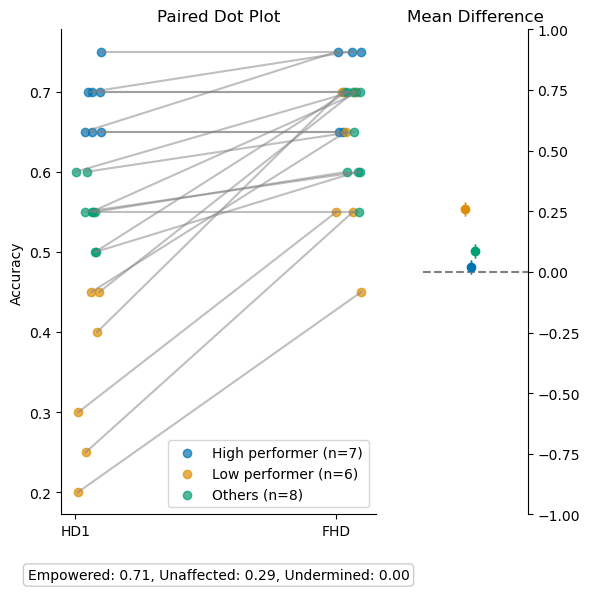

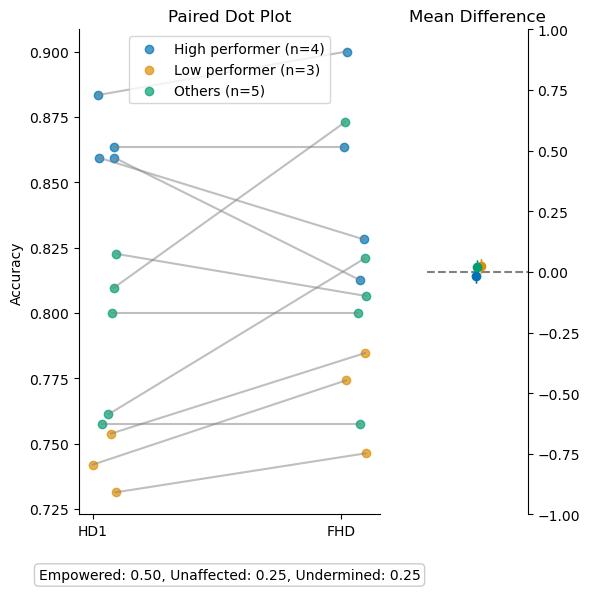

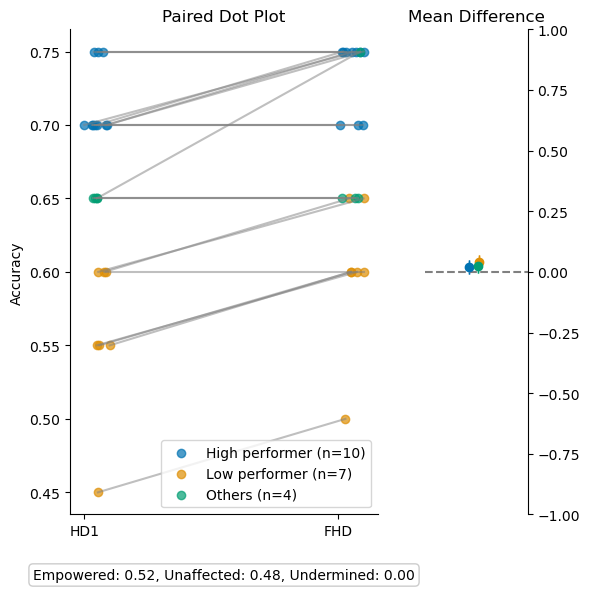

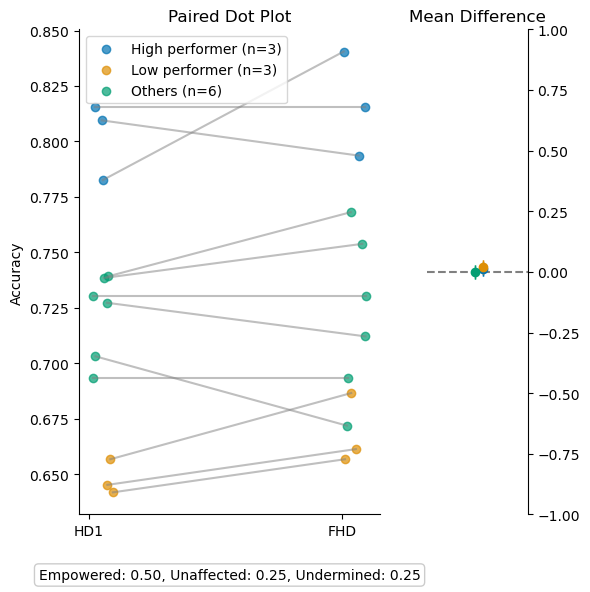

In [5]:
filename = "../data/sample_data.csv"

paired_plot(filename)